# CitiBike 
## Part 1: Data Cleaning, Imputing Missing Trips

### Overview
The Citi Bike system is a bicycle ride sharing system based in New York City where users can rent bikes for short periods of time. Users pick up a bike at a station, and ride to another station where they drop the bike off. The bikes are used for commuting, sight seeing, and general travelling throughout the city.

During high traffic times it can be difficult to determine if a Citi Bike will be available at a given station at a given time in the future. This could be especially useful for commuters to determine when they should leave for work or leave from work to ensure a Citi Bike is available.

<img src="citi_bike_rad_dude.jpg" width=600 height=400 />

The goal of this project is to develop a predictive model to enable Citi Bike users to determine the probability of a Citi Bike being available at somepoint in the future. This is based on the Citi Bike trips data set, as well as Citi Bike Stations Live feed. The trips data set contains information on a trip level, with a start and stop destination as well as some basic information regarding the user. The Station Live Feed contains information on stations, such as the total docks available at a given station.

### Data Modeling Challenge
The challenge of this project is that there is no information of how many bikes were available at a station at a given time. There is only information on bike's locations when they are moved. Thus we can only see a bike if it moves. Since we aren't starting at the beginning of time, there are bikes at stations, but the starting number of bikes isn't known.

A key dataset to help determine the starting distribution is the Stations "Live Feed" table. This contains information of the number of bikes at a given station, but it isn't actually a live feed. It is updated once a month, and was most recently updated at 5/30/20, the second to last day in our trips data. This can serve as a anchor point and we can use this in combination with the trips data to determine the number of bikes at a station at a given time.

However this approach is on valid with complete trips data. If we are missing additions or removals to a station, then the number of bikes at the station will be incorrect! Thus I implement an approach to identify and impute missing trips.

This notebook can be separated into the following parts:

- Initial data importing and cleaning

- Identifying missing trips, and imputing/simulating the missing trips

In [2]:
import pandas as pd
import numpy as np
import os
import stat
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt

### Read Trips Data

I start by importing the May 2020 trips dataset.

In [3]:
folder = os.getcwd()
zip_file = '/202005-citibike-tripdata.csv.zip'
zip_file_path = folder + zip_file

In [97]:
# Read compressed csv files
trips = pd.read_csv(zip_file_path, compression='zip')

# Replace all spaces with underscores in column names
trips.columns = [x.replace(' ', '_') for x in trips.columns]

# Round start and stop times to nearest second
trips['starttime'] = pd.to_datetime(trips.starttime)
trips['stoptime'] = pd.to_datetime(trips.stoptime)

In [98]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487890 entries, 0 to 1487889
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   tripduration             1487890 non-null  int64         
 1   starttime                1487890 non-null  datetime64[ns]
 2   stoptime                 1487890 non-null  datetime64[ns]
 3   start_station_id         1487890 non-null  int64         
 4   start_station_name       1487890 non-null  object        
 5   start_station_latitude   1487890 non-null  float64       
 6   start_station_longitude  1487890 non-null  float64       
 7   end_station_id           1487890 non-null  int64         
 8   end_station_name         1487890 non-null  object        
 9   end_station_latitude     1487890 non-null  float64       
 10  end_station_longitude    1487890 non-null  float64       
 11  bikeid                   1487890 non-null  int64         
 12  

In [99]:
print('Start Date: ' + str(min(trips.starttime)))
print('End Date: ' + str(max(trips.starttime)))
print('Number of unique starting stations: ' + str(len(set(trips['start_station_name']))))

Start Date: 2020-05-01 00:01:06.338000
End Date: 2020-05-31 23:59:48.066000
Number of unique starting stations: 923


The trips data set for the month of May 2020 has 1.49 million records of trips, with 923 unique starting stations.

### Request station information from API
The station live feed is requested from the web URL.

<img src="citi_bike_station.jpg" width=800/>

In [100]:
# Request Citi Bike Station Feed Data from API
station_feed_url = 'https://feeds.citibikenyc.com/stations/stations.json'
req = requests.get(station_feed_url)

# Convert results into Pandas Dataframe
stations = pd.DataFrame.from_dict(req.json())
stations = stations.stationBeanList.apply(pd.Series)
#stations.to_csv(folder + '/station_feed_' + dt.datetime.now().strftime('%m-%d-%y') + '.csv')
#stations = pd.read_csv(folder + '/station_feed_' + dt.datetime.now().strftime('%m-%d-%y') + '.csv')

In [101]:
print('Earliest Communication Time: ' + str(min(stations.lastCommunicationTime)))
print('Latest Communication Time: ' + str(max(stations.lastCommunicationTime)))

Earliest Communication Time: 2020-05-12 07:39:49 AM
Latest Communication Time: 2020-05-30 12:04:50 AM


In [428]:
station_feed_url = 'https://citibikenyc.com/stations/json/'
req = requests.get(station_feed_url)

In [102]:
# Find which stations are in the trips and station feed data sets
trips_stations = set(pd.concat([trips.start_station_id, trips.end_station_id]))
feed_stations = set(stations.id)

#Identify missing stations in the station feed data set
missing_stations = [station for station in trips_stations if station not in feed_stations]

print(len(missing_stations))
print(len(trips_stations))

2
934


The stations feed data table contains information for 932 out of 934 unique stations. The two stations which are not included in the reference table are shown below. The "NYCBS DEPOT" is the NYC Bike Share Depot.

In [103]:
trips[trips.start_station_id.isin(missing_stations)].drop_duplicates(subset='start_station_name')['start_station_name']

14272    Stuyvesant Walk & 1 Av Loop
Name: start_station_name, dtype: object

In [104]:
trips[trips.end_station_id.isin(missing_stations)].drop_duplicates(subset='end_station_name')['end_station_name']

20295     Stuyvesant Walk & 1 Av Loop
882506         NYCBS DEPOT - DELANCEY
Name: end_station_name, dtype: object

### Stack trips data into Operations dataframe with arrivals and departures
For easier processing, it is better to treat starts and stops as two different operations records. This next section transforms the data into this format.

We define a column based on if the operation is an arrival or departure. Another column "net_bikes" is 1 if a bike arrives at a station and -1 if a bike leaves the station. This will be used to track the number of bikes at a given station.

In [105]:
trips = trips.rename(columns={'tripduration': 'trip_duration', 
                              'starttime': 'start_time',
                              'stoptime': 'stop_time',
                              'bikeid': 'bike_id',
                              'usertype': 'user_type'})

starts = trips[['start_time', 'start_station_id', 'start_station_name', 'bike_id']]
stops = trips[['stop_time', 'end_station_id', 'end_station_name', 'bike_id']]

starts = starts.rename(columns={'start_time': 'op_time', 'start_station_id': 'station_id', 'start_station_name': 'station_name'})
stops = stops.rename(columns={'stop_time': 'op_time', 'end_station_id': 'station_id', 'end_station_name': 'station_name'})

starts['op_type'] = 'departure'
stops['op_type'] = 'arrival'

starts['net_bikes'] = -1
stops['net_bikes'] = 1

ops = pd.concat([starts, stops]).sort_values(by='op_time')

### Impute Missing Trips

98.34 % of bike trips start at the previous trip's end location. This is fairly good, but it is very important to have all trips.

I will assume that if a bike changed locations it was due to the result of a missing trip. This could be a result of missing ride data, or prehaps the bike was manually relocated by the Citi Bike team. In either case, by adding a new removal and addition, the number of bikes at each station will reflect the move.

The most unknown part of creating the new trip would be the time the bike left the previous station and arrived at the next station. I will choose to pick the midpoint between the previous arrival and the current departure time, with an 1 ms travel time. This will overestimate the number of bikes at the stations since the physical move will not be instaneous, and may actually have taken quite a bit longer.

In [108]:
trips['prev_end_station_id'] = trips.sort_values(by='start_time').groupby('bike_id')['end_station_id'].shift()
trips['prev_end_station_name'] = trips.sort_values(by='start_time').groupby('bike_id')['end_station_name'].shift()
trips['prev_stop_time'] = trips.sort_values(by='start_time').groupby('bike_id')['stop_time'].shift()

trips['station_match'] = trips.start_station_id == trips.prev_end_station_id

print('Percent of trips which connect %.2f' % (100*np.mean(trips[~trips.prev_end_station_id.isna()]['station_match'])))

Percent of trips which connect 98.34


In [123]:
missing = trips[(~trips.prev_end_station_id.isna()) & (~trips.station_match)].copy()
missing['time_gap'] = missing.start_time - missing.prev_stop_time
missing['missing_start_time'] = (missing.prev_stop_time + missing.time_gap/2)
missing['missing_stop_time'] = (missing.prev_stop_time + missing.time_gap/2) + pd.Timedelta(1, 'ms')

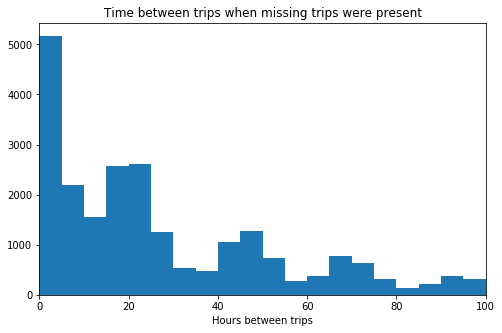

In [124]:
plt.hist(missing.time_gap.dt.total_seconds() / 3600, bins=np.linspace(0, 100, 21))
plt.xlim([0, 100])
plt.xlabel('Hours between trips')
plt.title('Time between trips when missing trips were present')
plt.show()

In [125]:
# Create dataframe of simulated data
sim_starts = missing[['missing_start_time', 'prev_end_station_id', 'prev_end_station_name', 'bike_id']]
sim_stops = missing[['missing_stop_time', 'start_station_id', 'start_station_name', 'bike_id']]

sim_starts = sim_starts.rename(columns={'missing_start_time': 'op_time', 'prev_end_station_id': 'station_id', 'prev_end_station_name': 'station_name'})
sim_stops = sim_stops.rename(columns={'missing_stop_time': 'op_time', 'start_station_id': 'station_id', 'start_station_name': 'station_name'})

sim_starts['op_type'] = 'departure'
sim_stops['op_type'] = 'arrival'

sim_starts['net_bikes'] = -1
sim_stops['net_bikes'] = 1

sim_ops = pd.concat([sim_starts, sim_stops]).sort_values(by='op_time')

In [126]:
# Append simulated trips data to ops data and refer to new dataframe as ops_full
ops_full = pd.concat([sim_ops, ops]).sort_values(by='op_time')
ops_full['sum_net_bikes'] = ops_full.groupby('station_id')['net_bikes'].cumsum()

# Calculate the new number of starting bikes
offset_full = ops_full[ops_full.op_type=='status'][['station_id', 'available_bikes', 'sum_net_bikes']].copy()
offset_full['starting_bikes'] = offset_full['available_bikes'] - offset_full['sum_net_bikes']

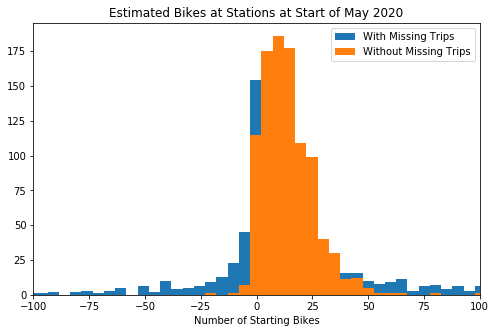

In [127]:
plt.rcParams['figure.figsize'] = 8, 5
plt.hist(offset.starting_bikes, bins=np.linspace(-300, 400, 140), label='With Missing Trips')
plt.hist(offset_full.starting_bikes, bins=np.linspace(-300, 400, 140), label='Without Missing Trips')
plt.xlabel('Number of Starting Bikes')
plt.title('Estimated Bikes at Stations at Start of May 2020')
plt.legend()
plt.xlim([-100, 100])
plt.show()

We can see that by augmenting missing trip data the starting offset data is within the expected range of between 0 - 50 bikes per station. More rigorously, we can merge the number of docks available at a station, and confirm that the number of starting bikes is within. Below is the distribution of the number of docks available at a station. Most docking stations have about 20-30 docks.

Text(0.5, 1.0, 'Citi Bike Station Sizes')

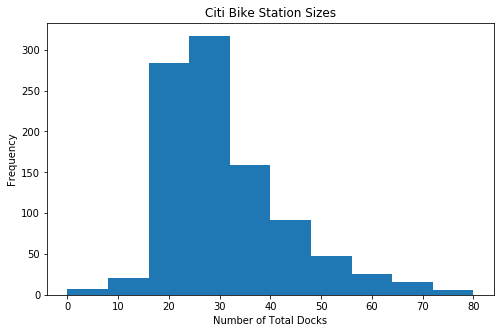

In [128]:
stations.totalDocks.plot.hist()
plt.xlabel('Number of Total Docks')
plt.title('Citi Bike Station Sizes')

The data shows some stations now have 0 total docks. Since the the total dock information is recorded at the end of the month it could be possible that these stations were closed. While we could remove these stations, it would be important to keep these stations as bikes might have been able to travel to them at some point in the month and this would break the continuity in bike routings established previously. 

In [129]:
# Merge the number of total docks
offset_full = offset_full.merge(stations[['id', 'totalDocks']], how='left', left_on='station_id', right_on='id')

# Get the percent of invalid starting bikes available
print('Percent of invalid starting bikes %.2f ' % (100*np.mean((offset_full.starting_bikes < 0) | (offset_full.starting_bikes > offset_full.totalDocks))))

Percent of invalid starting bikes 4.73 


The data shows that 4.73% stations do not fufill a valid starting criteria. This means that our data augmentation significantly improved our station data, but was not a complete solution. 

One possible solution for this could be bikes being removed from the system if they break. Since we would not have another trip after the bike was removed, the bike would remain assigned to the station. It would just appear that the bike has been sitting idle at a station for a long period of time. We could potentially solve this by adding simulated removals if a bike has been at a given station for a certain period of time. However, this would not be a perfect solution since it would be very possible for a bike to remain at a low traffic station for a long period of time.

<img src="service.jpg" width=900/>

A better solution would be to idenitfy broken bikes by modelling the selection of bikes at station. We could ask the question, what is the probability of this bike having not been selected after a certain number of customers have selected bikes from this location? This would assume that customers randomly select bikes from stations, which may not be exactly true. Customers may select bikes near the ends of the station at a higher frequency than the middle since customers usually approach the stations from the ends and they would likely pick bikes near the sides. However, we don't have information about where the bikes are docked within a given station.

One additional consideration that we need to make is that the probability of bike being selected is porportional to the number of other bikes at a station at given time. This will likely improve the accuracy of our model since there will be times with only a few bikes at a station. With only a few bikes, the probability of a bike being selected is higher, and thus there is greater signficance if the bike is not selected.

See Part 2 - Predicting Broken Bikes for my approach to this question.